# Biophysics of short term plasticity
### Roberto García Medina$^1$, Marco Arieli Herrera-Valdez$^1$
#### $^1$ Laboratorio de Fisiología de Sistemas, Facultad de Ciencias, Universidad Nacional Autónoma de México

In [1]:
import scipy as sc
import matplotlib.pylab as gr

Let $c$ represent the calcium concentration in the presynaptic terminal. Assume that calcium enters the presynaptic terminal via voltage-dependent calcium channels, causing an influx of calcium denoted by $c_{in}$, that goes back to its steady state with a time constant $\tau_c$. Assume that after calcium enters the terminal, it activates the biochemical machinery that releases neurotransmitter containing vesicles from the readily releasable pool. So let $r$  represent the activation of the release machinery, taking values between 0 and 1 to represent no-activation, or full activation, respectively. Cooperativity of calcium can be built into the model by assuming that the activation occurs at a rate $c^n\alpha_r$ nM$^n$/ms, with $n$ representing the cooperativity between calcium ions to activate the release machinery (Dextexhe et al. 1994), and a rate $\beta_r$ for the decay for activation. If the number of quanta in the readily releasable pool is represented by $q$, then the normalized quanta of neurotransmitter released can be thought of as $rq$.

The dynamics of  $(c, r, q)$ as state variables representing the presynaptic release can then be described by a system of the form
\begin{eqnarray}
\partial_t c &=& \frac{c_{\infty}-c}{\tau_c} + c_{in} ,\quad \textrm{presynaptic calcium concentration}
\\
\partial_t r &=& \alpha_r c^n (1-r) - \beta_r r,\quad \textrm{activation of release machinery by calcium}
\\
\partial_t q &=&  \frac{q_{\infty}-q}{\tau_q} + \delta q r,\quad \textrm{normalized number of quanta in readily releasable pool} 
\end{eqnarray}
with the parameters $c_{\infty}$ and $q_{\infty}$ represent the steady state concentration of calcium in the presynaptic terminal and the quanta in the readily releasable pool normalized by its maximum, respectively. The time constant $\tau_q$ defines how quick is the refilling of vesicles in the readily releasable pool.

The steady state and time constant for $r$ can be obtained from $\alpha_r$ and $\beta_r$ so that
\begin{equation}
\partial_t r = \frac{r_{\infty}(c)-r}{\tau_r}, 
\end{equation}
with 
$$r_{\infty}(c) = \frac{\alpha_r c^n}{\alpha_r c^n+ \beta_r} = \frac{c^n}{ c^n+ c_0^n},$$ 
with $c_0^n= \beta_r/\alpha_r$ and $\tau_r = \left(\alpha_r c^n+ \beta_r \right)$. For presynaptic terminals, $c_0$ should be around 150 nM.




### Calcium inputs as dirac combs

In [2]:
cPre={'c_PreInfty_muM':0.0001,'tau_c_Pre':50.0,'c_conv':0.0001,'c_halfAct_r_muM':0.3}
rPre={'alpha_r':2.0,'c_coop_r':4.0}
qPre={'q_Infty':1.0,'tau_q':25.0}
p=dict(); p.update(cPre);p.update(rPre);p.update(qPre)
print(p)

{'tau_c_Pre': 50.0, 'alpha_r': 2.0, 'c_coop_r': 4.0, 'q_Infty': 1.0, 'c_halfAct_r_muM': 0.3, 'c_PreInfty_muM': 0.0001, 'c_conv': 0.0001, 'tau_q': 25.0}


In [3]:
def RK2_Autonomous(f,pars, eParNames=[], eParList=[]):
    """Second-order Runge-Kutta method to solve x' = f(x,t) with U(t[0]) = U0.
    NOTES:
        This version is based on the algorithm presented in "Numerical
        Analysis", 6th Edition, by Burden and Faires, Brooks-Cole, 1997.
    """
    U=sc.zeros((pars['nSteps'], sc.prod(sc.shape(pars['ic']))),"float64")
    U[0]=pars['ic']
    for i in range(pars['nSteps']-1):
        for k in range(len(eParNames)):
            pars[eParNames[k]]= eParList[k][i]
        #t = stepSize * i
        k1 = pars['stepSize'] * f( U[i], pars) / 2.0
        U[i+1] = U[i] + pars['stepSize'] * f( U[i] + k1, pars)
    return U.transpose()

def DiracComb(p,spikeTrain):
    pulseInds = sc.int32(spikeTrain[spikeTrain<p['tMax']]/p['stepSize']);
    comb = sc.zeros(p['nSteps']);  comb[pulseInds]=p['pulseAmp']
    return comb

def Hill(u,c,n=2):
    uu = u**n
    return uu/(uu+ c**n)

### Presynaptic calcium dynamics

The dynamics of the presynaptic calcium concentration can be studied analitically by assuming that the calcium influx to the presynaptic terminal have the shape of a Dirac comb. That is, calcium influxes are modeled as one point inputs to the equation for $c$. In this case, the solution for $c$ can be calculated in parts, by observing two facts. First, in the absence of calcium input, the behavior of $c$ for  $t\geq t_0$   follows 
$$c(t)= c_{\infty}- \left( c_{\infty}-c_0\right) \exp\left(t_0-t\right),$$
for an initial condition $c_0=c(t_0)$ at an initial time $t_0$. 
Second, each presynaptic pulse of calcium of amplitude $h$ changes the value of $c$ to $c+ h$. The quantity $c+h$ can be regarded a new initial condition at each pulse. Then, if calcium pulses occur at times $t_1,...,t_n$, the function At the $n$th 

In [4]:
def presynCalcium(c,p):
    dc = (p['c_PreInfty_muM'] - c)/p['tau_c_Pre'] + p['c_PreIn']/p['stepSize']
    return sc.array([dc])

(array([0.001     , 0.00099972, 0.00099944, ..., 0.00104357, 0.00104327,
       0.00104298]), (40000,))


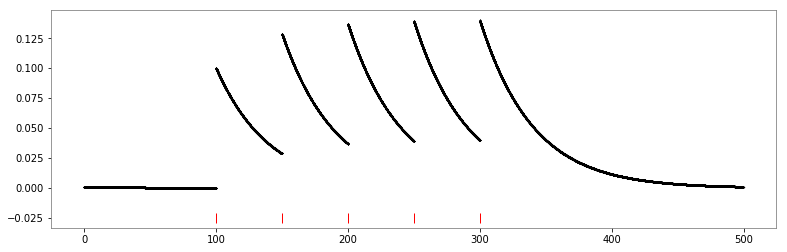

In [5]:
p['tMax'] = 500.0; p['stepSize'] = 1/80.0; 
p['sampTimes']= sc.arange(0,p['tMax'],p['stepSize'])
p['nSteps']= sc.int32(p['tMax']/p['stepSize']) 
p['pulseAmp']=0.1; p['firstPulseTime']=50.0; p['nPulses']=5; p['period']=50.0
p['tau_c_Pre']=40.0
#
spikeTrain = p['firstPulseTime'] + p['period']* sc.arange(1,p['nPulses']+1)
comb=DiracComb(p,spikeTrain)
p['ic']=sc.array([0.001])
c = RK2_Autonomous(f=presynCalcium,pars=p, eParNames=['c_PreIn'], eParList=[comb])[0]
print(c,sc.shape(p['sampTimes']))
#
pulseInds = sc.where(comb>0)[0]
pulseTimes=p['sampTimes'][pulseInds]
gr.figure(figsize=(13,4))
gr.plot(pulseTimes, comb[pulseInds]-1.25*p['pulseAmp'],'r|',lw=10,ms=10)
gr.plot(p['sampTimes'],c,'k.',ms=1)

The calcium peak at the $n$th pulse will be 


## Reduction to a 2D system for $c$ and $q$

Assume the activation of calcium dependent proteins in the presynaptic release machinery is instantaneous. That is,  $r=r_{\infty}(c)$. Then the system reduces to 
\begin{eqnarray}
\partial_t c &=& \frac{c_{\infty}-c}{\tau_c} + c_{in}, 
\\
\partial_t q &=&  \frac{q_{\infty}-q}{\tau_q} - \delta q r_{\infty}(c).
\end{eqnarray}

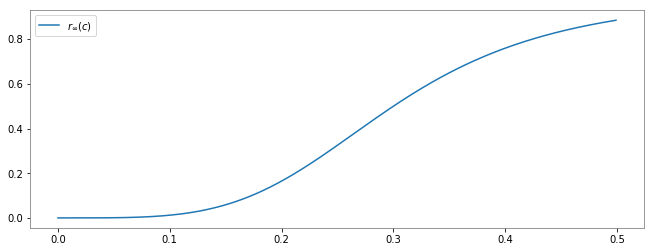

In [6]:
gr.figure(figsize=(11,4))
c = sc.arange(0,0.5,0.001)
rSS = Hill(c,p['c_halfAct_r_muM'],p['c_coop_r'])
gr.plot(c,rSS,label='$r_{\infty}(c)$')
gr.legend()

In [7]:
def presynSTSP(U,p):
    c,r,q= U
    rSS = Hill(c,p['c_halfAct_r_muM'],p['c_coop_r'])
    tau_r = rSS/p['alpha_r']
    dc = (p['c_PreInfty_muM'] - c)/p['tau_c_Pre'] + p['c_PreIn']/p['stepSize']
    dr = (rSS-r)/tau_r
    dq = (p['q_Infty']-q)/p['tau_q'] - r*q/p['stepSize']
    return sc.array([dc,dr,dq])

def presynSTSP_2D(U,p):
    c,q= U
    rSS = Hill(c,p['c_halfAct_r_muM'],p['c_coop_r'])
    dc = (p['c_PreInfty_muM'] - c)/p['tau_c_Pre'] + p['c_PreIn']/p['stepSize']
    dq = (p['q_Infty']-q)/p['tau_q'] - rSS*q/p['stepSize']
    return sc.array([dc,dq])

## Dynamics in the 2D model 



In [17]:
# Function to plot the 2D dynamics
def solve2DDynamics(p,spikeTrain,dispFig=1):
    p['ic'] = sc.array([0.0001,p['q_Infty']]); 
    pulses=DiracComb(p,spikeTrain)
    c2,q2=RK2_Autonomous(f=presynSTSP_2D,pars=p, eParNames=['c_PreIn'], eParList=[pulses])
    rSS2 = Hill(c2,p['c_halfAct_r_muM'],p['c_coop_r'])
    nt=q2*rSS2
    if dispFig==1:
        f1=gr.figure(figsize=(15,7)); rows=3; cols=1; ax=list()
        ax=[f1.add_subplot(rows,cols,n+1) for n in range(rows*cols)]
        ax[0].plot(p['sampTimes'],c2,'orange',label=r'$c(t)$')
        ax[0].plot(p['sampTimes'],rSS2,'b.',ms=1,alpha=0.4,label=r'$r_{\infty}(c)$')
        ax[1].plot(p['sampTimes'],q2,'k.',ms=1,label=r'$q(t)$')
        ax[2].plot(p['sampTimes'],nt,'k.',ms=1,label=r'$r_{\infty}(c)q(t)$')
        ax[0].plot(spikeTrain, sc.maximum(c2.max(),rSS2.max())*sc.ones(len(spikeTrain)),'r|', ms=10)
        ax[1].plot(spikeTrain, sc.ones(len(spikeTrain)),'r|', ms=10)
        ax[2].plot(spikeTrain, -0.01*sc.ones(len(spikeTrain)),'r|', ms=10)
        [ax[n].legend() for n in range(rows*cols)]
    return c2,q2,rSS2

In [18]:
p['c_PreIn']=0.0
p['pulseAmp']=0.1; p['firstPulseTime']=50.0; p['nPulses']=5; p['period']=50.0
spikeTrain = p['firstPulseTime'] + p['period']* sc.arange(1,p['nPulses']+1)
p['tMax'] = 500.0; p['stepSize'] = 1/80.0; 
p['sampTimes']= sc.arange(0,p['tMax'],p['stepSize'])
p['nSteps']= sc.int32(p['tMax']/p['stepSize']) 

### Facilitation

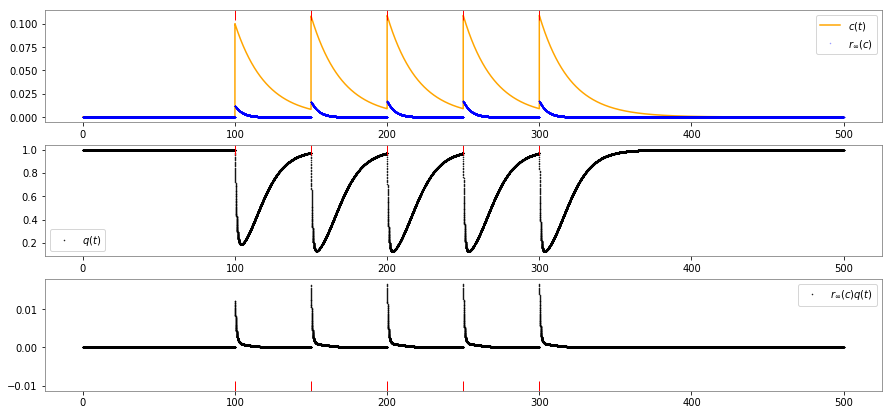

In [19]:
    p['c_halfAct_r_muM']=0.3; p['tau_c_Pre']=20.0; p['tau_q']=10.0; p['c_PreIn']=0.0
    c2,q2,rSS2= solve2DDynamics(p,spikeTrain)

### Depression

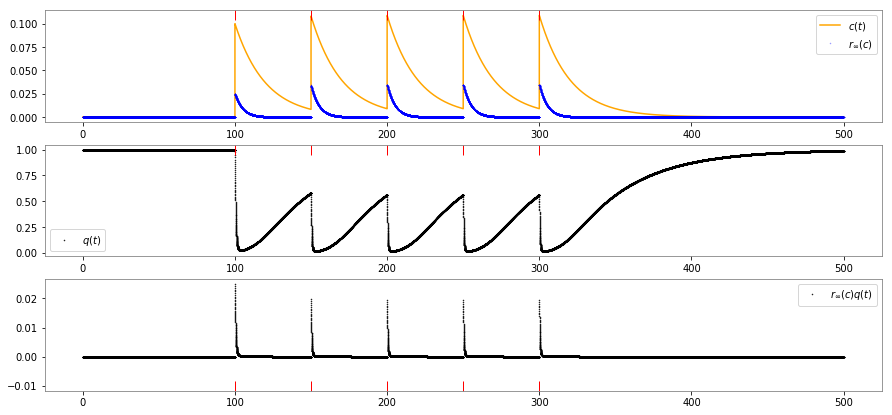

In [20]:
p['c_halfAct_r_muM']=0.25; p['tau_c_Pre']=20.0; p['tau_q']=40.0; p['c_PreIn']=0.0
c2,q2,rSS2= solve2DDynamics(p,spikeTrain)

### Biphasic up

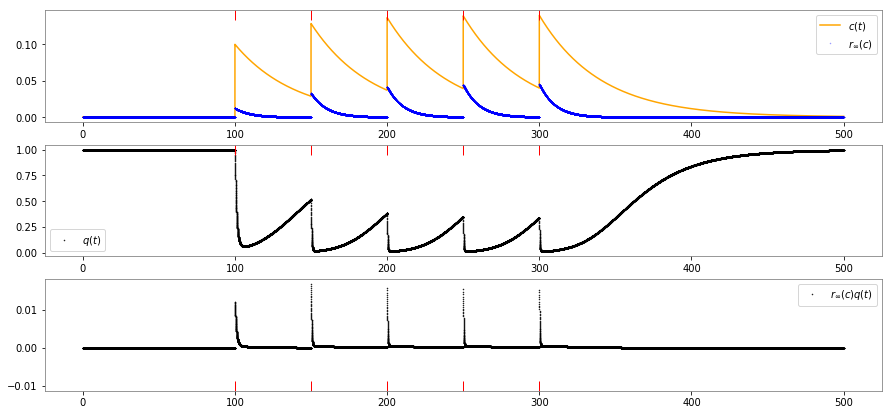

In [21]:
p['c_halfAct_r_muM']=0.3; p['tau_c_Pre']=40.0; p['tau_q']=30.0; p['c_PreIn']=0.0
c2,q2,rSS2= solve2DDynamics(p,spikeTrain)

## Randomly distributed spikes and switches between facilitation and depression

Now let us examine the short-term plasticity as a function of the interspike intervals. To do so, first let us generate spike trains with different firing rates (no longer periodic, regular spiking). 

In [22]:
def gammaTrain(meanISI, shape=2.0, nSpikes=100):
    isiSample= sc.zeros(nSpikes)
    isiSample=sc.random.gamma(shape, scale=meanISI/shape, size=nSpikes)
    spikeTrain= isiSample.cumsum()
    return spikeTrain

Four Gamma trains, each with with fixed mean rate

In [23]:
p['tMax'] = 6000.0; p['stepSize'] = 1/40.0; 
p['sampTimes']= sc.arange(0,p['tMax'],p['stepSize'])
p['nSteps']= sc.int32(p['tMax']/p['stepSize']) 
p['nPulses']=20;p['trainStart']= 500
#isis=sc.random.randint(1,100,4)
isis=[50,100,50,10,50,20,50]
print('Mean ISIs:',isis)
#
STs=list(); transitions=list()
for nn in isis:
    st=gammaTrain(meanISI=nn, shape=2.0, nSpikes=p['nPulses'])
    STs.append(st)
    transitions.append(st[-1])
for n in range(1,len(isis)):
    STs[n]= STs[n-1][-1] + STs[n]
transitions=[STs[n][-1] for n in range(len(isis))]

print('Transitions at times',transitions)
ST= sc.hstack(STs); ST= ST[ST<p['tMax']]  

('Mean ISIs:', [50, 100, 50, 10, 50, 20, 50])
('Transitions at times', [970.2981961382468, 2906.323690716248, 4099.200098157823, 4299.951365647913, 5177.751189489612, 5576.886581646492, 6685.757915865419])


### Facilitation profile

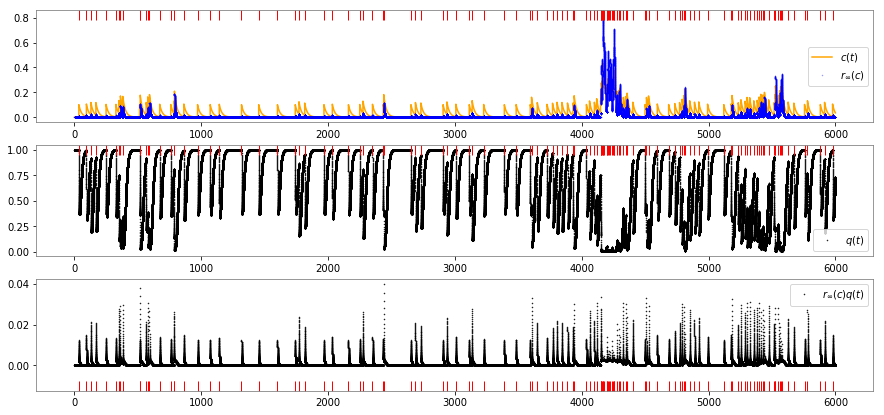

In [24]:
p['c_halfAct_r_muM']=0.3; p['tau_c_Pre']=20.0; p['tau_q']=10.0; p['c_PreIn']=0.0
cF,qF,rSSF= solve2DDynamics(p,spikeTrain=ST)

### Depression profile

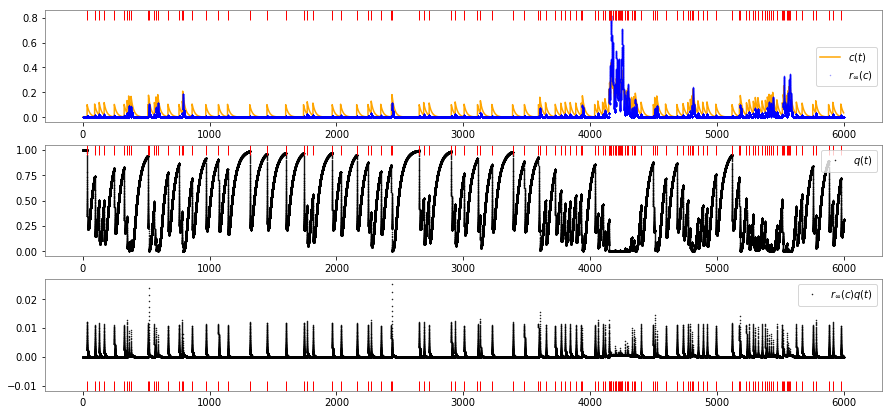

In [25]:
p['c_halfAct_r_muM']=0.3; p['tau_c_Pre']=20.0; p['tau_q']=40.0; p['c_PreIn']=0.0
cD,qD,rSSD= solve2DDynamics(p,spikeTrain=ST)

### Biphasic profile

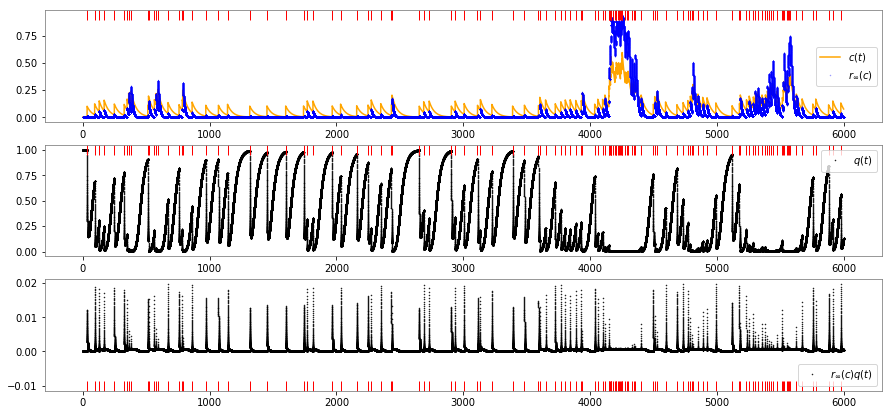

In [26]:
p['c_halfAct_r_muM']=0.3; p['tau_c_Pre']=40.0; p['tau_q']=30.0; p['c_PreIn']=0.0
cB,qB,rSSB= solve2DDynamics(p,spikeTrain=ST)

In [27]:
ntF=qF*rSSF;ntD=qD*rSSD;ntB=qB*rSSB
ntFD = ntF+ntD; ntFB = ntF+ntB; ntDB = ntD+ntB;
yPre = sc.zeros(len(ST)); yPre[1:]=1000.0/(ST[1:]-ST[:-1])

### Release from two different synaptic contacts, each with one profile of STSP

Facilitation, depression, and biphasic profiles combined 

[(0, 6000.0), (0, 6000.0), (0, 6000.0), (0, 6000.0)]

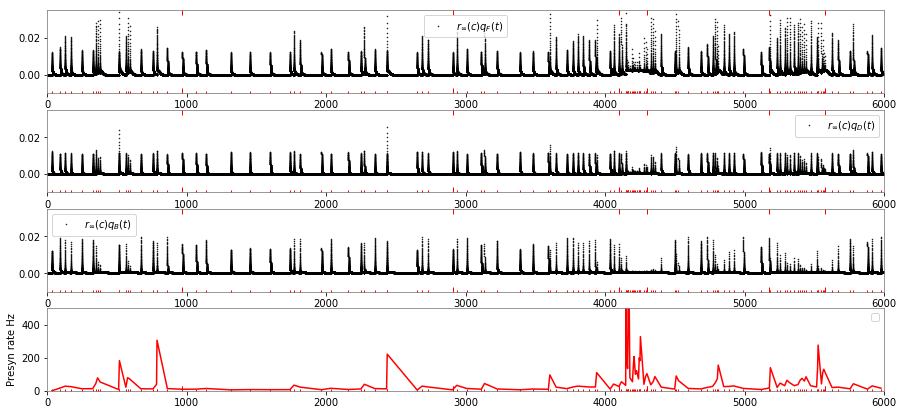

In [28]:
f1=gr.figure(figsize=(15,7)); rows=4; cols=1; ax=list()
ax=[f1.add_subplot(rows,cols,n+1) for n in range(rows*cols)]
ax[0].plot(p['sampTimes'],ntF,'k.',ms=1,label='$r_{\infty}(c)q_F(t)$')
ax[1].plot(p['sampTimes'],ntD,'k.',ms=1,label='$r_{\infty}(c)q_D(t)$')
ax[2].plot(p['sampTimes'],ntB,'k.',ms=1,label='$r_{\infty}(c)q_B(t)$')
ax[3].plot(ST, yPre,'r'); ax[3].set_ylabel('Presyn rate Hz'); ax[3].set_ylim(0,500)
for n in range(rows*cols):
    ax[n].plot(ST, -0.01*sc.ones(len(ST)),'r|', ms=5)
    for mm in range(len(transitions)):
        ax[n].plot([transitions[mm],transitions[mm]],[-0.01,0.035],'r|', ms=10)
[ax[n].legend() for n in range(rows*cols)]
[ax[n].set_ylim(-0.01,0.035) for n in range(rows*cols-1)]
[ax[n].set_xlim(0,p['tMax']) for n in range(rows*cols)]

Facilitation and depression added  

[(0, 6000.0), (0, 6000.0), (0, 6000.0), (0, 6000.0)]

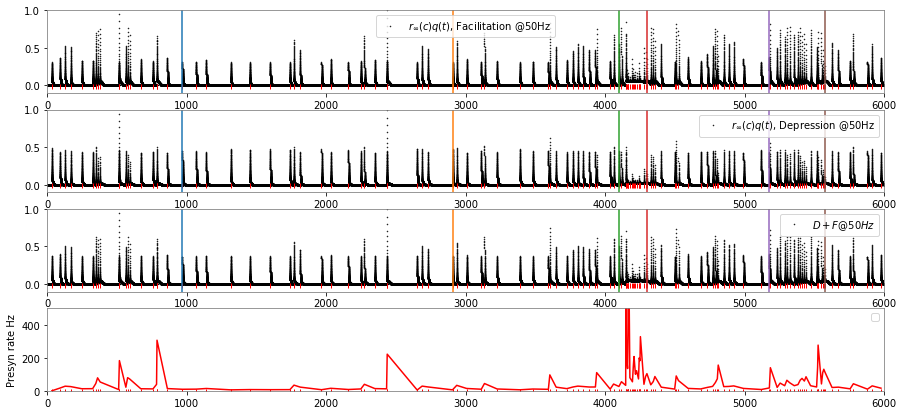

In [29]:
f1=gr.figure(figsize=(15,7)); rows=4; cols=1; ax=list()
ax=[f1.add_subplot(rows,cols,n+1) for n in range(rows*cols)]
ax[0].plot(p['sampTimes'],ntF/ntF.max(),'k.',ms=1,label='$r_{\infty}(c)q(t)$, Facilitation @50Hz')
ax[1].plot(p['sampTimes'],ntD/ntD.max(),'k.',ms=1,label='$r_{\infty}(c)q(t)$, Depression @50Hz')
ax[2].plot(p['sampTimes'],ntFD/ntFD.max(),'k.',ms=1, label='$D + F @50Hz$')
ax[3].plot(ST, yPre,'r'); ax[3].set_ylabel('Presyn rate Hz'); ax[3].set_ylim(0,500)
for n in range(rows*cols):
    ax[n].plot(ST, -0.01*sc.ones(len(ST)),'r|', ms=5)
    for mm in range(len(transitions)):
        ax[n].plot([transitions[mm],transitions[mm]],[-0.1,1], ms=10)
[ax[n].legend() for n in range(rows*cols)]
[ax[n].set_ylim(-0.1,1) for n in range(rows*cols-1)]
[ax[n].set_xlim(0,p['tMax']) for n in range(rows*cols)]

Facilitation and biphasic  

[(0, 6000.0), (0, 6000.0), (0, 6000.0), (0, 6000.0)]

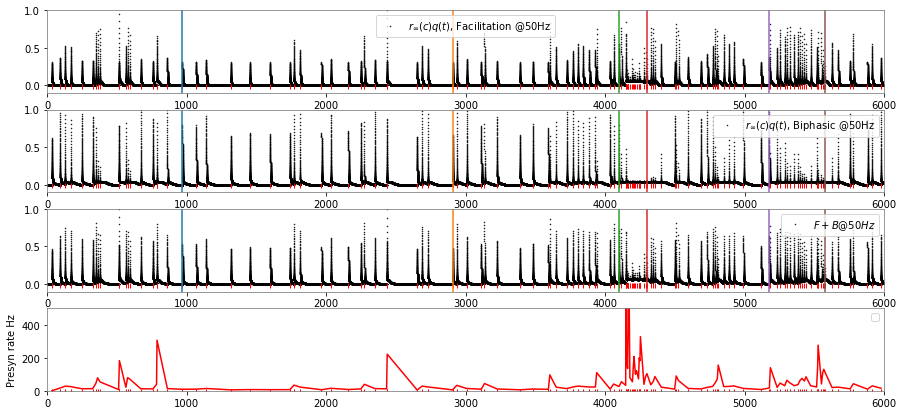

In [30]:
f1=gr.figure(figsize=(15,7)); rows=4; cols=1; ax=list()
ax=[f1.add_subplot(rows,cols,n+1) for n in range(rows*cols)]
ax[0].plot(p['sampTimes'],ntF/ntF.max(),'k.',ms=1,label='$r_{\infty}(c)q(t)$, Facilitation @50Hz')
ax[1].plot(p['sampTimes'],ntB/ntB.max(),'k.',ms=1,label='$r_{\infty}(c)q(t)$, Biphasic @50Hz')
ax[2].plot(p['sampTimes'],ntFB/ntFB.max(),'k.',ms=1, label='$F + B @50Hz$')
ax[3].plot(ST, yPre,'r'); ax[3].set_ylabel('Presyn rate Hz'); ax[3].set_ylim(0,500)
for n in range(rows*cols):
    ax[n].plot(ST, -0.01*sc.ones(len(ST)),'r|', ms=5)
    for mm in range(len(transitions)):
        ax[n].plot([transitions[mm],transitions[mm]],[-0.1,1], ms=10)
[ax[n].legend() for n in range(rows*cols)]
[ax[n].set_ylim(-0.1,1) for n in range(rows*cols-1)]
[ax[n].set_xlim(0,p['tMax']) for n in range(rows*cols)]

Depression and biphasic  

[(0, 6000.0), (0, 6000.0), (0, 6000.0), (0, 6000.0)]

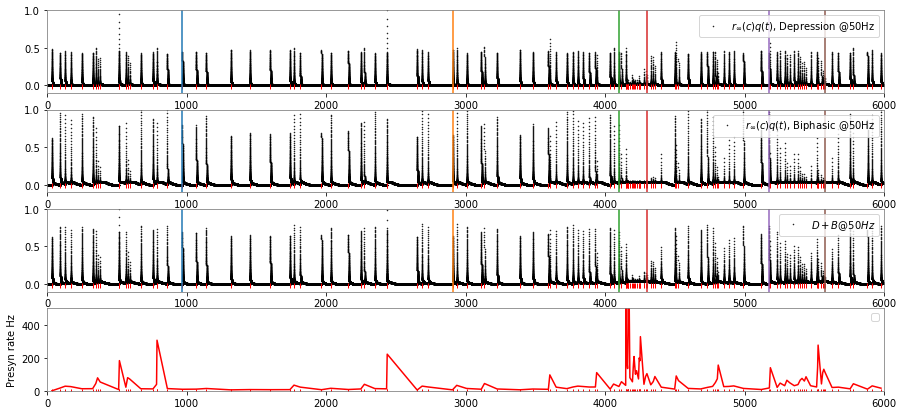

In [31]:
f1=gr.figure(figsize=(15,7)); rows=4; cols=1; ax=list()
ax=[f1.add_subplot(rows,cols,n+1) for n in range(rows*cols)]
ax[0].plot(p['sampTimes'],ntD/ntD.max(),'k.',ms=1,label='$r_{\infty}(c)q(t)$, Depression @50Hz')
ax[1].plot(p['sampTimes'],ntB/ntB.max(),'k.',ms=1,label='$r_{\infty}(c)q(t)$, Biphasic @50Hz')
ax[2].plot(p['sampTimes'],ntDB/ntDB.max(),'k.',ms=1, label='$D + B @50Hz$')
ax[3].plot(ST, yPre,'r'); ax[3].set_ylabel('Presyn rate Hz'); ax[3].set_ylim(0,500)
for n in range(rows*cols):
    ax[n].plot(ST, -0.01*sc.ones(len(ST)),'r|', ms=5)
    for mm in range(len(transitions)):
        ax[n].plot([transitions[mm],transitions[mm]],[-0.1,1], ms=10)
[ax[n].legend() for n in range(rows*cols)]
[ax[n].set_ylim(-0.1,1) for n in range(rows*cols-1)]
[ax[n].set_xlim(0,p['tMax']) for n in range(rows*cols)]

## Dynamics in the 3D model 

In [564]:
# Function to plot the 3D dynamics
def solve3DDynamics(p,pulses):
    c,r,q=RK2_Autonomous(f=presynSTSP,pars=p, eParNames=['c_PreIn'], eParList=[pulses])
    rSS = Hill(c,p['c_halfAct_r_muM'],p['c_coop_r'])
    #
    f1=gr.figure(figsize=(13,7)); rows=3; cols=1; ax=list()
    ax=[f1.add_subplot(rows,cols,n+1) for n in range(rows*cols)]
    ax[0].plot(p['sampTimes'],c,'orange',label='$c(t)$')
    ax[0].plot(p['sampTimes'],r,'b',lw=1,alpha=0.99,label='$r(t)$')
    ax[0].plot(p['sampTimes'],rSS,'b',lw=3,alpha=0.4,label='$r_{\infty}(c)$')
    ax[1].plot(p['sampTimes'],q,'k',label='$q(t)$')
    ax[2].plot(p['sampTimes'],q*rSS,'k',lw=3, alpha=0.3, label='$r_{\infty}(c)q(t)$')
    ax[2].plot(p['sampTimes'],q*r,'k', lw=1, label='$r_{\infty}(c)q(t)$')
    [ax[n].legend() for n in range(rows*cols)]
    return c,r,q

In [928]:
p['tMax'] = 5.0; p['stepSize'] = 1/80.0; 
p['sampTimes']= sc.arange(0,p['tMax'],p['stepSize'])
p['nSteps']= sc.int32(p['tMax']/p['stepSize']) 
p['pulseAmp']=0.1; p['nPulses']=0; p['period']=0.0
p['tau_c_Pre']=20.0
comb=periodicDiracComb(p)
p['c_halfAct_r_muM']=0.3; p['tau_c_Pre']=40.0; p['tau_q']=50.0; p['c_PreIn']=0.0
# 
p['ic'] = sc.array([0.001,0.0001, p['q_Infty']]);
#
#c,r,q=solve3DDynamics(p,pulses=comb)